# ===============================================================
# Exploratory Data Analysis (EDA) - Steel Industry Energy Dataset
# Autores: Equipo 32
# Fecha: Octubre 2025
# Materia MLOps
# Objetivo: Analizar las variables predictoras y su relación con Usage_kWh
# ===============================================================
#
# El dataset consta de registros acumulados de 15 minutos, del 01/01/2018 al 31/12/2018
# en dichos registros de presentan los ddatos operativos de la planta fundidora Daewoo e
# Corea del Sur, la propuesta de valor, es realizar la predición del consumo energético
#

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import missingno as msno
from scipy.stats import pearsonr, spearmanr

# --- Configuración visual ---
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("deep")
pd.set_option("display.float_format", lambda x: f"{x:,.3f}")

# --- Cargar dataset ---
file_path = "../../data/raw/steel_energy_modified.csv"   # Ajusta si tu archivo está en otra ruta
df = pd.read_csv(file_path)

# --- Vista general ---
print("Dimensiones del dataset:", df.shape)
print("\nTipos de datos:\n", df.dtypes)
display(df.head())


Dimensiones del dataset: (35740, 12)

Tipos de datos:
 date                                    object
Usage_kWh                               object
Lagging_Current_Reactive.Power_kVarh    object
Leading_Current_Reactive_Power_kVarh    object
CO2(tCO2)                               object
Lagging_Current_Power_Factor            object
Leading_Current_Power_Factor            object
NSM                                     object
WeekStatus                              object
Day_of_week                             object
Load_Type                               object
mixed_type_col                          object
dtype: object


,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type,mixed_type_col
0,01/01/2018 00:15,3.17,2.95,0.0,NaN,73.21,100.0,900.0,Weekday,Monday,Light_Load,649
1,01/01/2018 00:30,4.0,4.46,0.0,0.0,66.77,100.0,1800.0,Weekday,Monday,Light_Load,NaN
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700.0,Weekday,Monday,Light_Load,696
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600.0,Weekday,Monday,Light_Load,630
4,01/01/2018 01:15,3.82,4.5,0.0,0.0,64.72,100.0,4500.0,Weekday,Monday,Light_Load,325


## Deben ser 96 registros diarios, (4 por hora x 24H), * 365 días que hubo en 2018, en teriora deberian ser 35,040 registros, actualmente existen 35,740, por lo que hay 700 registros de mas


In [28]:
# --- Limpieza inicial: renombrar columnas con nombres seguros ---
df.columns = [col.strip().replace(" ", "_").replace("(", "").replace(")", "").replace(".", "_") for col in df.columns]
print("\nNombres de columnas limpios:")
print(df.columns.tolist())

# --- Forzar columnas específicas a tipo numérico ---
num_cols_to_force = [
    "Usage_kWh",
    "Lagging_Current_Reactive_Power_kVarh",
    "Leading_Current_Reactive_Power_kVarh",
    "CO2tCO2",
    "Lagging_Current_Power_Factor",
    "Leading_Current_Power_Factor",
    "NSM"
]

for col in num_cols_to_force:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# --- Verificar conversión ---
print("\nVerificación de tipos tras conversión:")
print(df[num_cols_to_force].dtypes)

# --- Valores faltantes ---
print("\nValores nulos por columna:")
print(df.isnull().sum())
msno.matrix(df)
plt.title("Mapa de valores faltantes")
plt.show()

# --- Estadísticas descriptivas ---
print("\nEstadísticas descriptivas:")
display(df.describe(include="all").T)

# --- Detección de duplicados ---
duplicates = df.duplicated().sum()
print(f"\nFilas duplicadas: {duplicates}")


Nombres de columnas limpios:
['date', 'Usage_kWh', 'Lagging_Current_Reactive_Power_kVarh', 'Leading_Current_Reactive_Power_kVarh', 'CO2tCO2', 'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM', 'WeekStatus', 'Day_of_week', 'Load_Type', 'mixed_type_col']

Verificación de tipos tras conversión:
Usage_kWh                               float64
Lagging_Current_Reactive_Power_kVarh    float64
Leading_Current_Reactive_Power_kVarh    float64
CO2tCO2                                 float64
Lagging_Current_Power_Factor            float64
Leading_Current_Power_Factor            float64
NSM                                     float64
dtype: object

Valores nulos por columna:
date                                     339
Usage_kWh                                516
Lagging_Current_Reactive_Power_kVarh     530
Leading_Current_Reactive_Power_kVarh     554
CO2tCO2                                  510
Lagging_Current_Power_Factor             572
Leading_Current_Power_Factor          

NameError: name 'msno' is not defined

In [33]:
# --- Convertir columna de tiempo ---
# Ajusta el nombre si tu dataset tiene otro encabezado de fecha
time_col = None
for col in df.columns:
    if "date" in col.lower() or "time" in col.lower():
        time_col = col
        break

if time_col:
    df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
    df = df.dropna(subset=[time_col])
    df = df.sort_values(by=time_col)
    print(f"\n✅ Columna temporal detectada y convertida: {time_col}")
else:
    print("\n⚠️ No se encontró columna temporal (DateTime).")

# --- Agregado diario ---
if time_col:
    df_daily = (
        df.groupby(df[time_col].dt.date)
        .agg({
            "Usage_kWh": "sum",
            "Lagging_Current_Reactive_Power_kVarh": "sum",
            "Leading_Current_Reactive_Power_kVarh": "sum",
            "CO2tCO2": "sum",
            "Lagging_Current_Power_Factor": "mean",
            "Leading_Current_Power_Factor": "mean",
            "NSM": "max"   # ejemplo: acumulado de segundos en el mes
        })
        .reset_index()
        .rename(columns={time_col: "Date"})
    )
    print("\n📅 Datos agregados a nivel diario:")
    display(df_daily.head())
else:
    df_daily = df.copy()


✅ Columna temporal detectada y convertida: date

📅 Datos agregados a nivel diario:


,Date,Usage_kWh,Lagging_Current_Reactive_Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2tCO2,Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM
0,2018-01-01,325.620,162.550,825.950,0.000,83.987,154.188,"85,500.000"
1,2018-01-02,"5,990.450","2,497.390",109.730,3.000,86.547,238.603,"85,500.000"
2,2018-01-03,"1,693.670","1,336.160","1,003.430","1,382.700",84.510,82.101,"1,620,000.000"
3,2018-01-04,811.610,415.600,"1,957.810",0.000,81.325,55.193,"1,953,000.000"
4,2018-01-05,492.800,"1,057.350",815.080,0.000,80.665,76.803,"1,368,000.000"


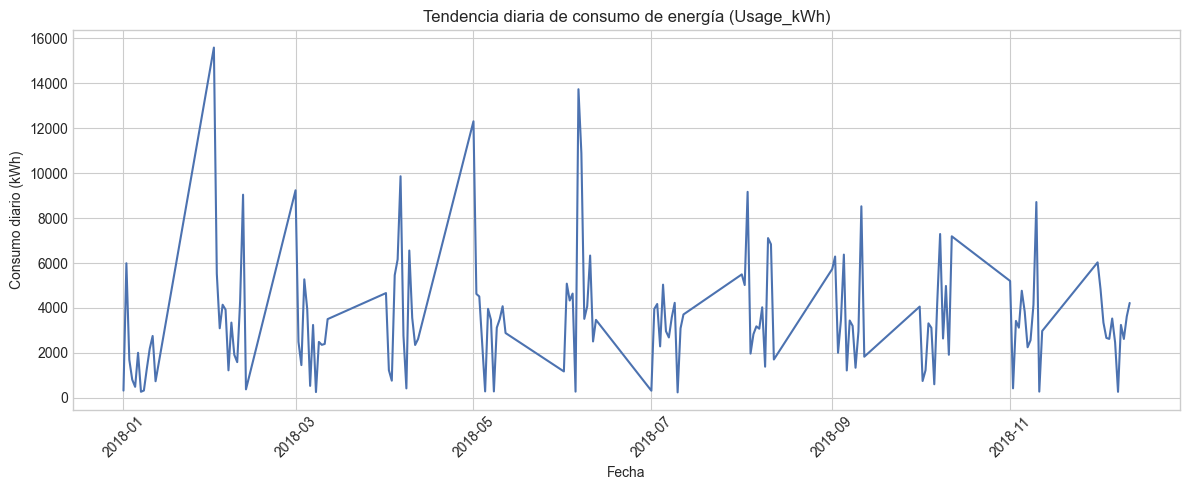

In [34]:
# --- Graficar tendencia diaria de energía ---
plt.figure(figsize=(12,5))
sns.lineplot(x="Date", y="Usage_kWh", data=df_daily, color="#4C72B0")
plt.title("Tendencia diaria de consumo de energía (Usage_kWh)")
plt.xlabel("Fecha")
plt.ylabel("Consumo diario (kWh)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

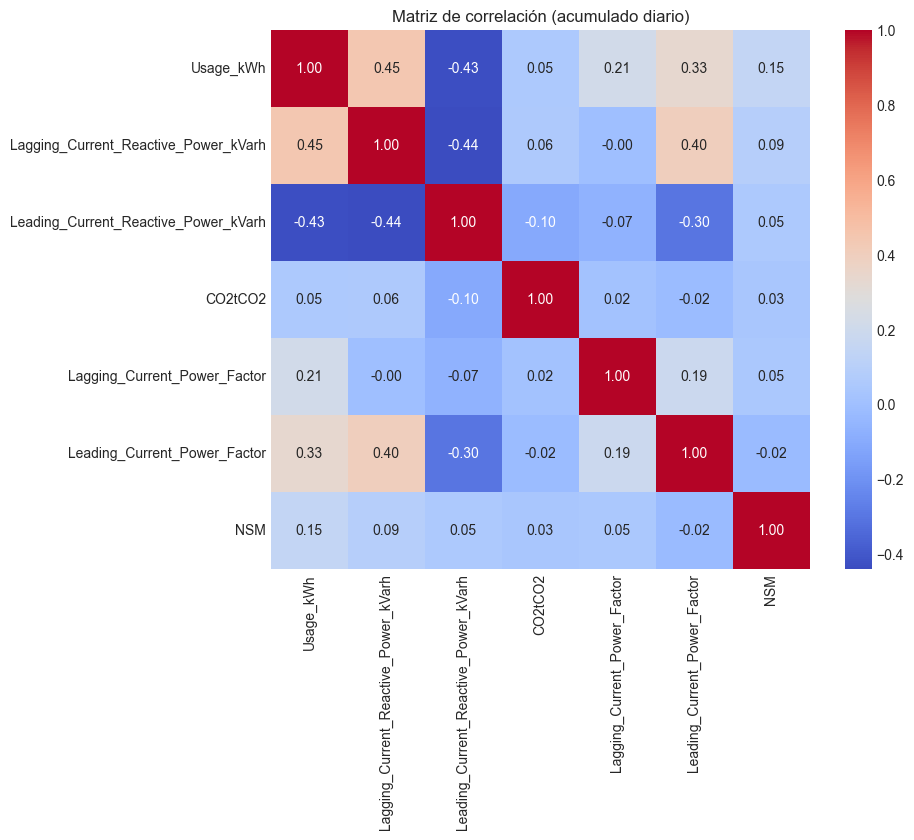

In [35]:
# --- Graficar correlaciones con acumulado diario ---
corr_daily = df_daily.corr(numeric_only=True)
plt.figure(figsize=(9,7))
sns.heatmap(corr_daily, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Matriz de correlación (acumulado diario)")
plt.show()

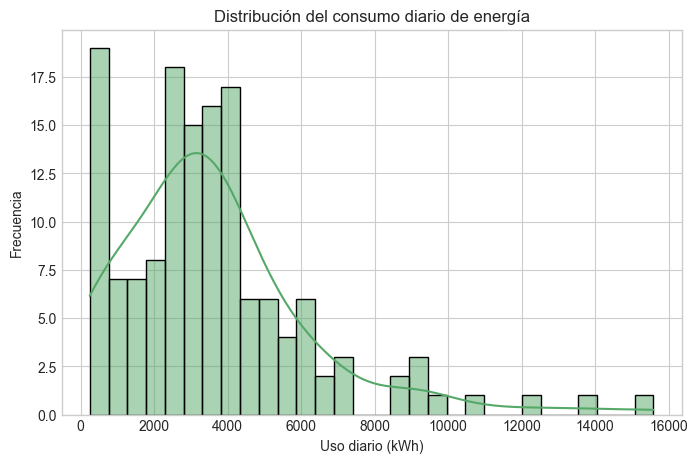

In [36]:
# --- Distribución del consumo diario ---
plt.figure(figsize=(8,5))
sns.histplot(df_daily["Usage_kWh"], bins=30, kde=True, color="#55A868")
plt.title("Distribución del consumo diario de energía")
plt.xlabel("Uso diario (kWh)")
plt.ylabel("Frecuencia")
plt.show()

In [29]:
# --- Identificación de tipos de variables ---
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

print(f"\nColumnas numéricas ({len(num_cols)}): {num_cols}")
print(f"Columnas categóricas ({len(cat_cols)}): {cat_cols}")


Columnas numéricas (7): ['Usage_kWh', 'Lagging_Current_Reactive_Power_kVarh', 'Leading_Current_Reactive_Power_kVarh', 'CO2tCO2', 'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM']
Columnas categóricas (5): ['date', 'WeekStatus', 'Day_of_week', 'Load_Type', 'mixed_type_col']


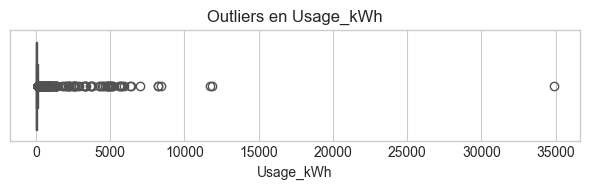

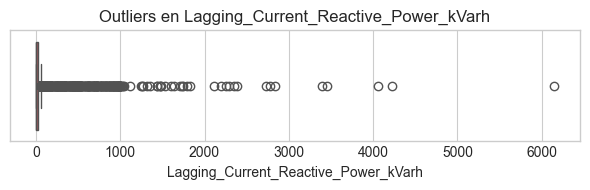

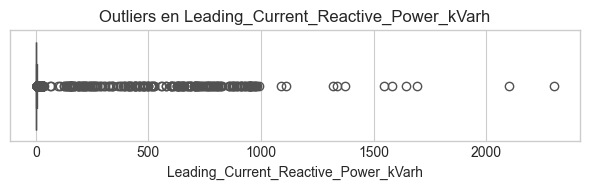

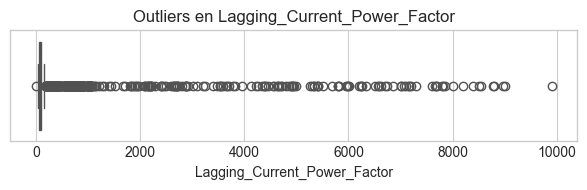

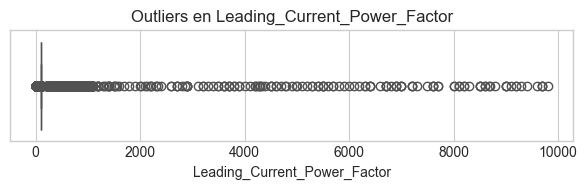

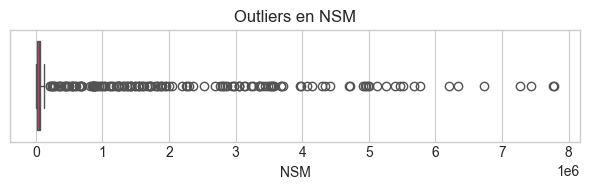

In [23]:
# --- Boxplots para outliers ---
for col in num_cols:
    plt.figure(figsize=(6, 2))
    sns.boxplot(x=df[col], color="#C44E52")
    plt.title(f"Outliers en {col}")
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()